# Data exploration and cleaning

Explore a sampling of comments on subreddit "r/dementia" and "r/Alzheimers" from Jan. 2013 through Aug. 2016, as obtained from Google's BigQuery interface to the reddit corpus compiled by Jason Baumgartner at pushshift.io.

In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
import nltk

In [3]:
%matplotlib inline  

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

## First look. 

Concatentate csv files containing posts.

In [5]:
df_d_2013 = pd.read_csv('reddit_data/Alz_2013.csv')
df_d_2014 = pd.read_csv('reddit_data/Alz_2014.csv')
df_A_2013 = pd.read_csv('reddit_data/dementia_2013.csv')
df_A_2014 = pd.read_csv('reddit_data/dementia_2014.csv')

df = pd.concat((df_d_2013, df_d_2014, df_A_2013, df_A_2014))

In [6]:
for subreddit in ['Alz', 'dementia']:
    for year in ['2015', '2016']:
        for month in ['{0:02}'.format(i) for i in xrange(1, 12+1)]:
            if year == '2016' and month == '09': break
            df_temp = pd.read_csv('reddit_data/%s_%s_%s.csv' % (subreddit, year, month))
            df = pd.concat((df, df_temp))

Re-index so that there is a unique index for each record in the merged dataframe.

In [7]:
df = df.set_index([np.arange(df.shape[0])])

In [8]:
df.columns

Index([u'archived', u'author', u'author_flair_css_class', u'author_flair_text',
       u'body', u'controversiality', u'created_utc', u'distinguished',
       u'downs', u'gilded', u'id', u'link_id', u'name', u'parent_id',
       u'removal_reason', u'retrieved_on', u'score', u'score_hidden',
       u'subreddit', u'subreddit_id', u'ups'],
      dtype='object')

In [9]:
df.shape

(6671, 21)

In [10]:
df.dtypes

archived                  float64
author                     object
author_flair_css_class    float64
author_flair_text         float64
body                       object
controversiality            int64
created_utc                 int64
distinguished              object
downs                     float64
gilded                      int64
id                         object
link_id                    object
name                       object
parent_id                  object
removal_reason            float64
retrieved_on              float64
score                       int64
score_hidden              float64
subreddit                  object
subreddit_id               object
ups                         int64
dtype: object

In [11]:
df.head(3)

,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,gilded,...,link_id,name,parent_id,removal_reason,retrieved_on,score,score_hidden,subreddit,subreddit_id,ups
0,1.0,Monkey_socks,NaN,NaN,Yes I agree with playing music from her youth....,0,1366116799,NaN,0.0,0,...,t3_18dt64,t1_c9g8uez,t3_18dt64,NaN,1.431540e+09,2,0.0,Alzheimers,t5_2r8fp,2
1,1.0,angrydroid,NaN,NaN,How old is he? He's diagnosed clinically and i...,0,1387888752,NaN,0.0,0,...,t3_1tldwq,t1_ce96ssi,t3_1tldwq,NaN,1.428004e+09,1,0.0,Alzheimers,t5_2r8fp,1
2,1.0,kmobrien,NaN,NaN,I am currently a third year student at hertfor...,0,1364268805,NaN,0.0,0,...,t3_1b0r56,t1_c92ic4s,t3_1b0r56,NaN,1.431705e+09,1,0.0,Alzheimers,t5_2r8fp,1


In [12]:
for comment in df["body"].values[:2]:
    print comment
    print ""

Yes I agree with playing music from her youth. Dementia and Alzheimer's is in effect the stripping away of the more short term memories. My grandmother has dementia also. The brain works backwards in effect and causes her to eventually forget the more recent things and remember her earlier memories as a child and young adult. We played my grandmother music from her youth and she was dancing in her chair, clapping along and knew a lot of the words. The earliest memories will be the last to go in this disease and so things from this time are more likely to spark her interest or cause her to remember things and find enjoyment and pleasure. Hope this helps!

How old is he? He's diagnosed clinically and is still driving a truck?



## Simplify timestamp to the day of the year.

In [13]:
df_p = df.copy()

Time appears to be measured in seconds.  The difference between the earliest comment and the most recent should be about 3.67 years.

In [14]:
times_sorted = np.sort(df_p.created_utc.values)

In [15]:
print 'Time span of dataset in years:', (max(times_sorted) - min(times_sorted)) / (365 * 24 * 60 * 60) 

Time span of dataset in years: 3.66260771816


Choose a round number for midnight Jan. 1, 2013.  (Some guessing hear on the exact number to use.)

In [16]:
zero_time_pt = min(times_sorted) - (min(times_sorted) / (3600 * 24 * 365.25) % 1) * (3600 * 24 * 365.25)
print 'Chosen zero time point for dataset:', zero_time_pt

Chosen zero time point for dataset: 1356976800.0


Compare to the timestamp of the first comment in the dataset.

In [17]:
print 'Time of first comment in dataset', min(times_sorted)

Time of first comment in dataset 1357158524


In [18]:
print 'Sanity check:', min(times_sorted) > zero_time_pt

Sanity check: True


Create column of timestamps measured in days since Jan. 1, 2013 (rather than seconds since 1970?).

In [19]:
df_p['day'] = df_p.created_utc.apply(lambda x: (x - zero_time_pt) / 86400)

Sort comments chronologically.

In [20]:
df_p = df_p.sort_values('day')

Some final checks.

In [21]:
print df_p.day.min(), df_p.day.max()
print df_p.day.max() / 365

2.10328703704 1338.95510417
3.6683701484


## Remove some columns and then take a first pass at cleaning the data.

I had retained "distinguished" but then found that it only contained two non-nan entries, both "moderator".  "gilded" and "downs" and "controversiality" are similarly uninteresting.  "score" and "ups" contain identical entries, so I simply retain "score".

In [22]:
df_q = df_p[["day", "body", "author", "score"]].copy()

In [23]:
df_q.columns

Index([u'day', u'body', u'author', u'score'], dtype='object')

In [24]:
df_q.dtypes

day       float64
body       object
author     object
score       int64
dtype: object

In [25]:
df_q.head(3)

,day,body,author,score
990,2.103287,Thank you!,jean_genie,1
848,2.855660,[deleted],[deleted],1
955,2.857778,No one knows how to prevent Alzheimer disease....,[deleted],1


In [26]:
df_q.shape

(6671, 4)

In [27]:
df_q.ix[df_q[df_q["author"]=="[deleted]"].index, "author"] = "unknown"

In [28]:
df_q.head(3)

,day,body,author,score
990,2.103287,Thank you!,jean_genie,1
848,2.855660,[deleted],unknown,1
955,2.857778,No one knows how to prevent Alzheimer disease....,unknown,1


In [29]:
df_q.shape

(6671, 4)

In [30]:
df_q = df_q.drop(df_q[df_q["body"]=="[deleted]"].index)
df_q = df_q.drop(df_q[df_q["body"]=="[removed]"].index)

In [31]:
df_q.head(3)

,day,body,author,score
990,2.103287,Thank you!,jean_genie,1
955,2.857778,No one knows how to prevent Alzheimer disease....,unknown,1
58,2.890174,Alzheimer’s Disease: A Daughter’s Tale,jcampbell77,1


In [32]:
df_q.describe()

,day,score
count,6287.000000,6287.000000
mean,913.497269,1.809289
std,319.791294,1.538060
min,2.103287,-8.000000
25%,692.304416,1.000000
50%,996.363472,1.000000
75%,1177.115226,2.000000
max,1338.955104,65.000000


In [33]:
df_q.shape

(6287, 4)

There are no nan values at this point.

In [34]:
np.sum(df_q.isnull().values, 0)

array([0, 0, 0, 0])

Convert comments to numpy strings.

In [35]:
df_u = df_q.copy()

In [36]:
df_u.body = df_u.body.apply(lambda x: np.str(x))

In [37]:
df_u.head(3)

,day,body,author,score
990,2.103287,Thank you!,jean_genie,1
955,2.857778,No one knows how to prevent Alzheimer disease....,unknown,1
58,2.890174,Alzheimer’s Disease: A Daughter’s Tale,jcampbell77,1


## EDA.

Histogram comment length.

In [38]:
comments = df_u.body.values

In [39]:
comment_lengths = []
for comment in comments:
    comment_lengths.append(len(comment))

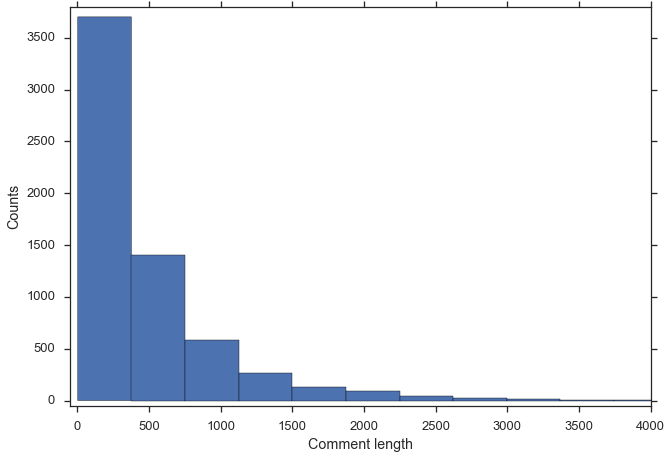

In [40]:
plt.figure()
plt.hist(comment_lengths, bins=20)
plt.xlabel('Comment length')
plt.ylabel('Counts')
plt.xlim(-50, 4000)
plt.ylim(-50, 3800);

Average # of comments per day.

In [41]:
df_u.shape[0] / df_u.day.max()

4.695452431851983

Number of comments per day.

In [42]:
num_days = int(np.around(df_u.day.max()))

In [43]:
comments_per_day = np.zeros(num_days)
days = df_u.day.values

k = 0
for day in days:
    while day > (k+1):
        k += 1
    comments_per_day[k] += 1 

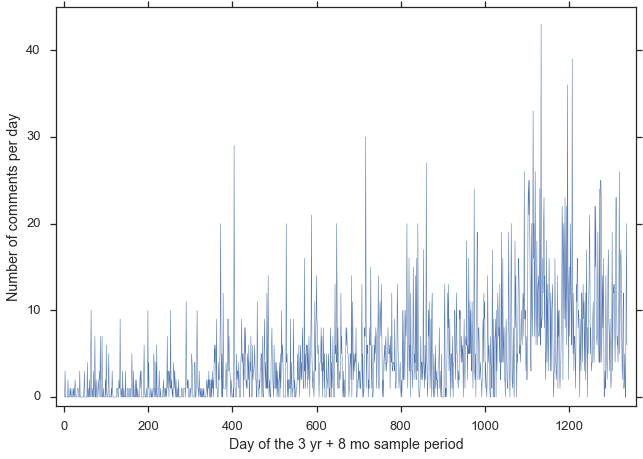

In [44]:
plt.figure()
plt.plot(comments_per_day, lw=0.5)
plt.xlabel('Day of the 3 yr + 8 mo sample period')
plt.ylabel('Number of comments per day')
plt.xlim(-20, 1360)
plt.ylim(-1, 45);

Number of unique users (ignore unknowns).

In [45]:
len(np.unique(df_u.author[df_u.author!='unknown']))

1466

Time series of unique users per month.

In [46]:
num_months = int(np.around(df_u.day.max()) / (365.25 / 12) + 1)
print num_months

44


In [47]:
month_bins = np.linspace(0, num_days, num_months+1)[1:]
print month_bins
print len(month_bins)

[   30.43181818    60.86363636    91.29545455   121.72727273   152.15909091
   182.59090909   213.02272727   243.45454545   273.88636364   304.31818182
   334.75         365.18181818   395.61363636   426.04545455   456.47727273
   486.90909091   517.34090909   547.77272727   578.20454545   608.63636364
   639.06818182   669.5          699.93181818   730.36363636   760.79545455
   791.22727273   821.65909091   852.09090909   882.52272727   912.95454545
   943.38636364   973.81818182  1004.25        1034.68181818  1065.11363636
  1095.54545455  1125.97727273  1156.40909091  1186.84090909  1217.27272727
  1247.70454545  1278.13636364  1308.56818182  1339.        ]
44


In [48]:
users_per_month = np.zeros(num_months)
days = df_u.day.values
authors = df_u.day.values

k = 0
authors_this_month = []
for day, author in zip(days, authors):
    if day < month_bins[k]:
        authors_this_month.append(author)
    else:
        users_per_month[k] = len(np.unique(authors_this_month))
        k += 1
        authors_this_month = []
        
users_per_month[k] = len(np.unique(authors_this_month))     

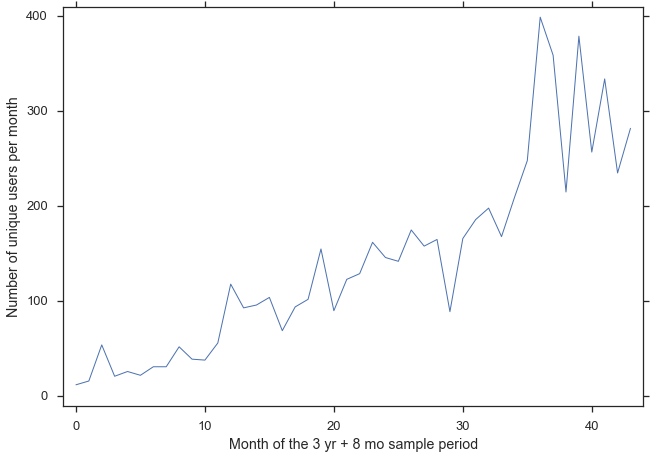

In [49]:
plt.figure()
plt.plot(users_per_month, lw=1.)
plt.xlabel('Month of the 3 yr + 8 mo sample period')
plt.ylabel('Number of unique users per month')
plt.xlim(-1, 44)
plt.ylim(-10, 410);

Gather a list of hyperlinks.

In [50]:
re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', comments[3])

['http://canhekick.it/projects/1140727526/the-leap)',
 'http://canhekick.it/reddit-faq)']

In [51]:
hyperlinks = []
indices = []
for i, comment in enumerate(comments):
    # from http://stackoverflow.com/questions/6883049/regex-to-find-urls-in-string-in-python
    https = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', comment)
    
    if len(https) > 0:
        for item in https:
            hyperlinks.append(item)
            indices.append(i)

In [52]:
hyperlinks[:10]

['http://canhekick.it/projects/1140727526/the-leap)',
 'http://canhekick.it/reddit-faq)',
 'http://www.j-alz.com/issues/31/scheltens_supplement.pdf',
 'http://www.sciencedaily.com/releases/2013/01/130115143852.htm)',
 'http://www.medicalnewstoday.com/releases/257402.php',
 'http://forum.alzheimers.org.uk/forum.php',
 'http://www.amazon.com/Creating-Moments-Alzheimers-Dementia-ebook/dp/B001NJ17YA/ref=dp_kinw_strp_1',
 'http://www.amazon.com/Ill-Be-Seeing-You-Alzheimers/dp/1479286729',
 'http://www.medicalnewstoday.com/releases/258095.php',
 'http://www.alz.org/apps/we_can_help/support_groups.asp)']

In [53]:
print len(hyperlinks)
print len(np.unique(hyperlinks))

946
819


Investigate score distribution.

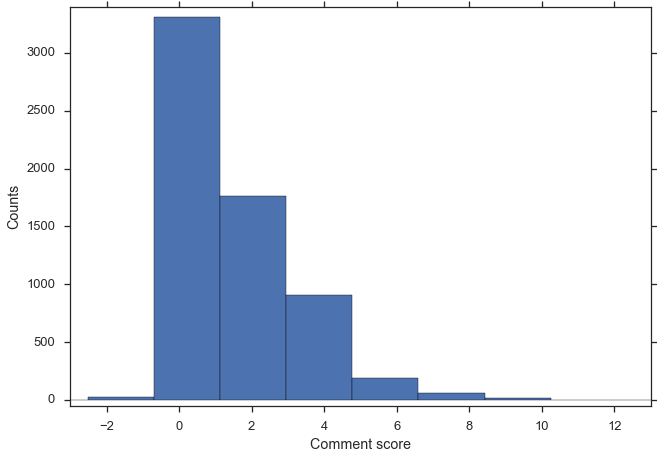

In [54]:
plt.figure()
plt.hist(df_u.score, bins=40)
plt.xlabel('Comment score')
plt.ylabel('Counts')
plt.xlim(-3, 13)
plt.ylim(-50, 3400);

In [55]:
df_u_by_score = df_u.sort_values('score')

Low scores correspond to some truly aweful comments.  High scores correspond to helpful comments.

## Additional data cleaning.

In [56]:
df_r = df_u.copy()

In [57]:
df_r = df_r.drop(df_q[df_q["author"]=="I_WantMyMother2Die"].index)

In [58]:
df_r.shape

(6262, 4)

In [59]:
df_r = df_r.drop(df_r[df_r["score"] < 1].index)

In [60]:
df_r.shape

(6182, 4)

In [61]:
df_r.head(3)

,day,body,author,score
990,2.103287,Thank you!,jean_genie,1
955,2.857778,No one knows how to prevent Alzheimer disease....,unknown,1
58,2.890174,Alzheimer’s Disease: A Daughter’s Tale,jcampbell77,1


Apply Andrew Ng's Exercise 6 NLP filters to each comment.

In [62]:
comments_p = []
for comment in df_r.body.values:
    
    comment = comment.lower()
    
    # Strip all HTML
    comment = re.sub(r'<[^<>]+>', ' ', comment)
    
    # Handle Numbers
    comment = re.sub(r'[0-9]+', 'number', comment)
    
    # Handle URLS
    comment = re.sub(r'(http|https)://[^\s]*', 'httpaddr', comment)
    
    # Handle Email Addresses
    comment = re.sub(r'[^\s]+@[^\s]+', 'emailaddr', comment)
    
    # Handle $ sign
    comment = re.sub(r'[$]+', 'dollar', comment)
    
    # Handle punctuation and special ascii characters
    comment = re.sub(r'[@$/\\#,-:&*+=\[\]?!(){}\'\">_<;%]+', '', comment)  
    
    comments_p.append(comment)

In [63]:
comments_p[:3]

['thank you',
 'no one knows how to prevent alzheimer disease the site is solely to make money selling a book to frightened people and the person who has posted this has a reddit history of two posts both promoting the same site',
 'alzheimer\xe2\x80\x99s disease a daughter\xe2\x80\x99s tale']

Create a data column containing cleaned comments.

In [64]:
df_r['clean_body'] = comments_p

In [65]:
print df_r.body[1]
print df_r.clean_body[1]

How old is he? He's diagnosed clinically and is still driving a truck?
how old is he hes diagnosed clinically and is still driving a truck


Create a data column containing clearned comment length in characters.

In [66]:
df_r['body_length'] = df_r.clean_body.apply(lambda x: len(x))

In [67]:
df_r.head(2)

,day,body,author,score,clean_body,body_length
990,2.103287,Thank you!,jean_genie,1,thank you,9
955,2.857778,No one knows how to prevent Alzheimer disease....,unknown,1,no one knows how to prevent alzheimer disease ...,212


Drop comments that are too short (likely uninformative or spam) or too long (possible pasting in of comments from elsewhere).

In [68]:
df_r = df_r.drop(df_r[df_r["body_length"] < 20].index)
df_r = df_r.drop(df_r[df_r["body_length"] > 1500].index)

Drop comments that the community ranked low.

In [69]:
df_r = df_r.drop(df_r[df_r["score"] < 2].index)

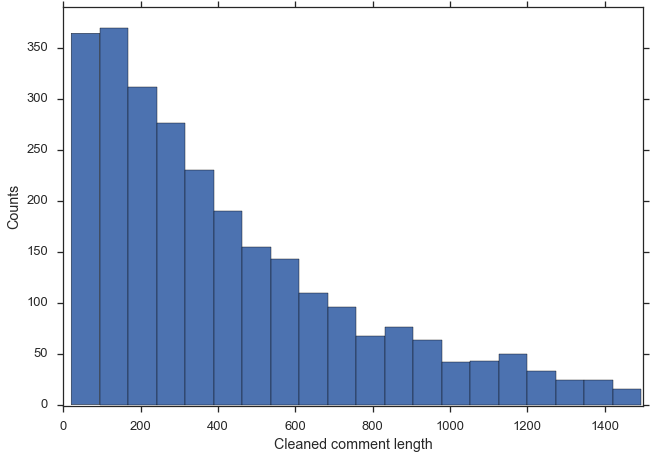

In [70]:
plt.figure()
plt.hist(df_r['body_length'].values, bins=20)
plt.xlabel('Cleaned comment length')
plt.ylabel('Counts')
plt.xlim(-1, 1500)
plt.ylim(-1, 390);

Sort df.

In [71]:
df_r = df_r.sort_values('day')

Reset df index.

In [72]:
df_r = df_r.set_index([np.arange(df_r.shape[0])])

In [73]:
df_r.head(5)

,day,body,author,score,clean_body,body_length
0,9.631065,Here is a graph of what the project has raised...,canhekickit,3,here is a graph of what the project has raised...,808
1,21.679086,"My grandma has Alzheimer's and said to me ""if ...",WomblesMama,4,my grandma has alzheimers and said to me if iv...,120
2,31.079988,"I always describe it more as a panini, because...",Lordica,2,i always describe it more as a panini because ...,59
3,33.395556,Sounds tough. I'm a speech pathologist and I...,soobaaaa,2,sounds tough im a speech pathologist and i s...,394
4,37.574757,Don't you have any other family member to help...,placidway,2,dont you have any other family member to help ...,134


In [74]:
df_r.shape

(2680, 6)

In [75]:
df_r.describe()

,day,score,body_length
count,2680.000000,2680.000000,2680.000000
mean,912.145771,2.729104,418.773881
std,319.476507,1.324156,335.973433
min,9.631065,2.000000,20.000000
25%,681.064540,2.000000,154.000000
50%,999.614184,2.000000,321.000000
75%,1173.485567,3.000000,589.250000
max,1338.166701,15.000000,1495.000000


In [76]:
df_r.columns

Index([u'day', u'body', u'author', u'score', u'clean_body', u'body_length'], dtype='object')

# Additional EDA.

Create a word cloud as an additional check that the high-frequency words are as expected.

In [77]:
from wordcloud import WordCloud

In [78]:
text = ' '.join(comment for comment in comments_p)

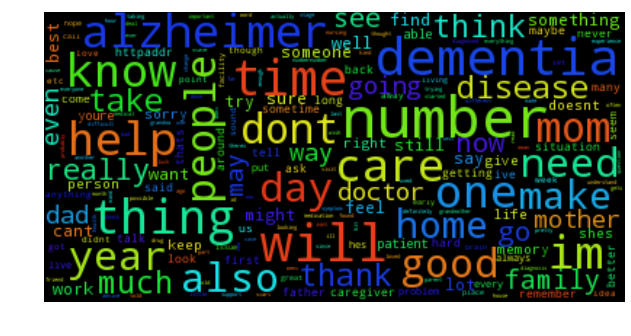

In [79]:
plt.figure()
wordcloud = WordCloud(max_font_size=40, relative_scaling=0.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off");

## Push final pandas dataframe to a postgres db.

In [80]:
from sqlalchemy import create_engine
from sqlalchemy.sql import text

In [81]:
data = df_r.values

Create a tuple of dictionaries - one dictionary per example in the dataset.

In [82]:
data_as_tuple = tuple([{   
    'Id': i, 
    'Day': data[i, 0], 
    'Body': data[i, 1],
    'Author': data[i, 2],
    'Score': data[i, 3],
    'Clean_body': data[i, 4],
    'Body_length': data[i, 5]} 
    for i in xrange(len(data))])

Simultaneously create a database called "insight" and an SQLAlchemy engine object.  This is the starting point for SQLAlchemy applications.  
(See http://docs.sqlalchemy.org/en/latest/core/engines.html.)

NOTE:  
A PostgreSQL SERVER MUST BE RUNNING LOCALLY ON YOUR MACHINE, AND THE DATABASE "insight" MUST EXIST.  
TO CREATE THAT DATABASE ON MY MAC OSX LAPTOP FROM THE COMMAND LINE OF A BASH SHELL, I TYPED:

```$ createdb -h localhost -p 5432 -U postgres insight```

In [85]:
eng = create_engine('postgresql:///insight')

Connect to the postgres database and create a table containing the data.

In [86]:
with eng.connect() as con:

    con.execute(text('DROP TABLE IF EXISTS reddit'))
    con.execute(text('''CREATE TABLE reddit(
        Id INTEGER PRIMARY KEY, Day FLOAT, Body VARCHAR(20000), Author VARCHAR(20000), Score INT, 
        Clean_body VARCHAR(20000), Body_length INT)'''))
    
    for line in data_as_tuple:
        con.execute(text('''INSERT INTO reddit(Id, Day, Body, Author, Score, Clean_body, Body_length) 
            VALUES(:Id, :Day, :Body, :Author, :Score, :Clean_body, :Body_length)'''), **line)